This analysis was aided and inspired by methods used in the following two analyses. Thanks to kaggle user @adyg1234 for inspiring these visualizations!

https://www.kaggle.com/code/adyg1234/sf-uber-mobility-data-analysis/notebook
https://www.kaggle.com/code/adyg1234/sf-muni-route-stops-visualization-basic-version/notebook

In [2152]:
!pip install shapely contextily geopandas

In [2153]:
# import necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import shapefile as shp
import matplotlib.pyplot as plt
import shapely.wkt
import contextily as ctx
import re
from sklearn.cluster import KMeans
from shapely.geometry import Point

In [2154]:
#df of polygon traversals
traversals = pd.read_csv("san_francisco-traversals_Q12020_10-6 2.csv")
traversals

,hexid,dayType,traversals,wktGeometry
0,8c283082e2561ff,weekday,1032,POLYGON ((-122.40206953427416 37.7714520565948...
1,8c283082e2569ff,weekday,892,POLYGON ((-122.40213131278361 37.7712839848525...
2,8c283082e2549ff,weekday,990,POLYGON ((-122.40261741706829 37.7710182076871...
3,8c283082e262bff,weekday,398,POLYGON ((-122.40422609029275 37.7703400835882...
4,8c283082e2633ff,weekday,416,POLYGON ((-122.40467724483703 37.7706977341065...
...,...,...,...,...
99808,8c283082b1133ff,weekend,21,POLYGON ((-122.41806344987806 37.7934582399412...
99809,8c283082aa435ff,weekend,16,POLYGON ((-122.4082247679837 37.78587989719168...
99810,8c283082ed013ff,weekend,16,POLYGON ((-122.38621641899094 37.7554074420424...
99811,8c2830829c0b5ff,weekend,21,POLYGON ((-122.43687269402756 37.7782012588867...


Let's take a look at how much of the data is weekend vs weekday. It looks like weekdays have more traversals per day, suggesting there is a significant effect of people ubering as part of their commute.


In [2155]:
weekend_vs_weekday_counts = traversals.groupby("dayType")
print(r'Weekdays: ', (weekend_vs_weekday_counts.get_group('weekday')['traversals'].sum() / 5))
print(r'Weekends: ', (weekend_vs_weekday_counts.get_group('weekend')['traversals'].sum() / 2))

Weekdays:  1633074.2
Weekends:  1366037.0


Because our analysis is focusing on commuters, lets restrict our analysis to weekdays only. 


In [2156]:
traversals_weekday = traversals[traversals["dayType"] == "weekday"]
traversals_weekday

,hexid,dayType,traversals,wktGeometry
0,8c283082e2561ff,weekday,1032,POLYGON ((-122.40206953427416 37.7714520565948...
1,8c283082e2569ff,weekday,892,POLYGON ((-122.40213131278361 37.7712839848525...
2,8c283082e2549ff,weekday,990,POLYGON ((-122.40261741706829 37.7710182076871...
3,8c283082e262bff,weekday,398,POLYGON ((-122.40422609029275 37.7703400835882...
4,8c283082e2633ff,weekday,416,POLYGON ((-122.40467724483703 37.7706977341065...
...,...,...,...,...
58850,8c283082812edff,weekday,18,POLYGON ((-122.41887484198638 37.7695811511974...
58851,8c283095b49d5ff,weekday,15,POLYGON ((-122.47836218945763 37.7841624393078...
58852,8c283082d0091ff,weekday,16,POLYGON ((-122.44361733143197 37.7614153268847...
58853,8c283082a3591ff,weekday,16,POLYGON ((-122.40527549937688 37.7917891322882...


We can see that our new df now contains the expected number of rows when filtering our weekends (58855).

Let's take a look at the full values in the wktGeometry column.

In [2157]:
traversals_weekday['wktGeometry'].iloc[0]

'POLYGON ((-122.40206953427416 37.77145205659484, -122.40197821984188 37.77152436450601, -122.40200775554032 37.771620128151376, -122.40212860581218 37.771643583808135, -122.4022199201558 37.77157127584822, -122.4021903843163 37.771475512280276, -122.40206953427416 37.77145205659484))'

Let's look at some of our data for the number of traversals in each polygon.

In [2158]:
traversals_weekday['traversals'].describe()

count    58855.000000
mean       138.737083
std        230.120922
min         15.000000
25%         29.000000
50%         59.000000
75%        141.000000
max       3864.000000
Name: traversals, dtype: float64

looks like our max is 3864 traversals. How many polygons have more than 500 traversals? 

In [2159]:
traversals_weekday_500_plus = traversals_weekday[traversals_weekday['traversals']>500]
traversals_weekday_500_plus.shape[0]

3416

3416 polygons. Seems like enough to do our analysis on, as we only want to look at areas where there is a lot of traffic. It wouldn't make sense to put in a train line if people wouldn't use it!


Now, lets use geopandas and the shapely.wkt library to parse our wktGeometry columns into something we can plot.

<Axes: >

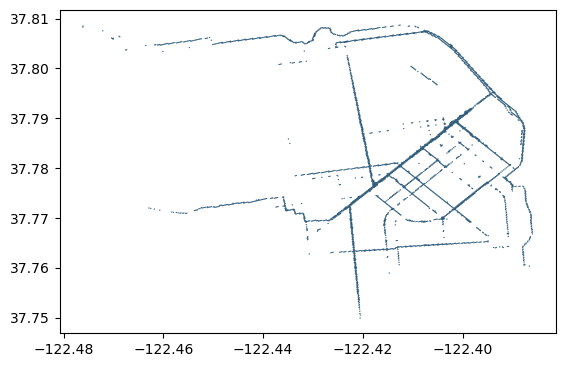

In [2160]:
gp_df_weekday = gpd.GeoDataFrame(traversals_weekday_500_plus, geometry = traversals_weekday_500_plus["wktGeometry"].apply(shapely.wkt.loads))
gp_df_weekday.plot(edgecolor = "black", linewidth=0.1)

Looks like the most traversed areas in the city are fairly concentrated already. Let's plot it on top of a San Francisco shapefile. 

In [2161]:
gp_df_weekday.crs = "EPSG:4326"
gp_df_weekday = gp_df_weekday.to_crs(epsg=3857)

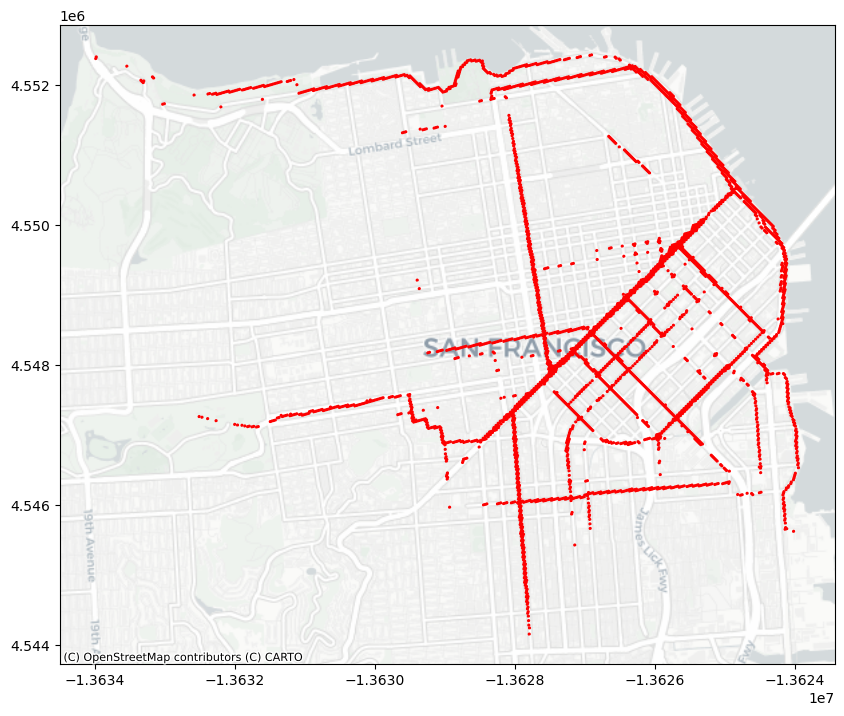

In [2162]:
ax = gp_df_weekday.plot(figsize=(10, 10), alpha=1.0, edgecolor='red')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()

Now, we'll plot the centroids of the polygons (useful for later analysis)


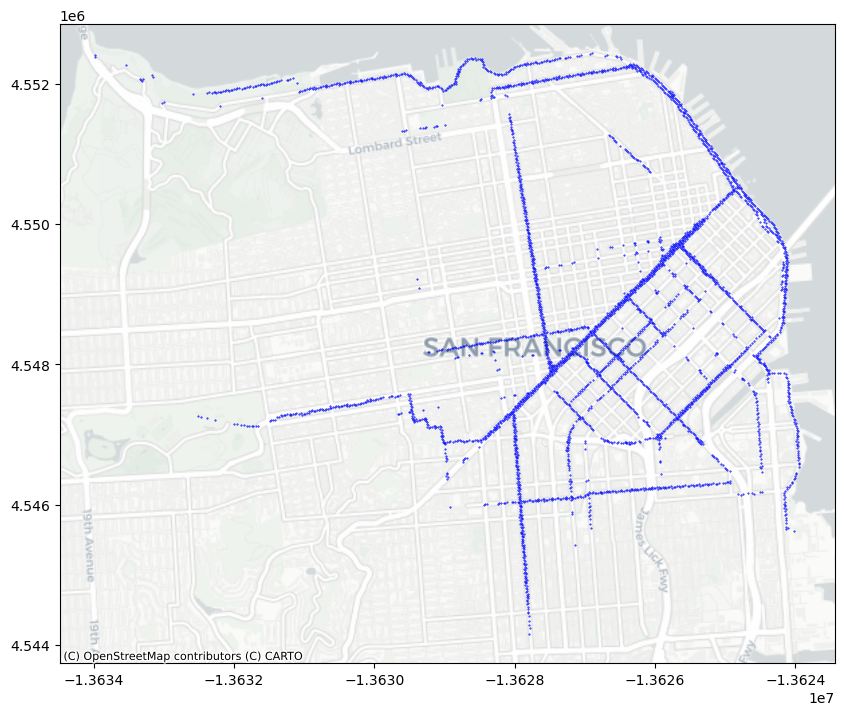

In [2163]:
ax1 = gp_df_weekday.centroid.plot(figsize=(10, 10), alpha=1.0, edgecolor='blue', markersize = 0.2)
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
plt.show()

Now, let's import some data about SF public transportation.


In [2164]:
transit = pd.read_csv("Muni_Simple_Routes.csv")
transit.groupby("SERVICE_CA")['SERVICE_CA'].value_counts()

SERVICE_CA
Cable Car          6
Connector         24
Frequent Local    22
Grid              34
Historic           2
Muni Metro        12
OWL                2
Other              8
Owl                2
Rapid Bus          8
Specialized       10
Name: count, dtype: int64

Because we're only looking at the expansion of light rail systems in san francisco, we can filter out all routes that are different types.


In [2165]:
transit = transit[transit['SERVICE_CA'] == "Muni Metro"]
transit

,PATTERN,PATTERNID,ROUTE_NAME,DIRECTION,PATTERN_TYPE,SUB_TYPE,PATTERN_VERSION,LINEABBR,SIGNID,SERVICE_CA,shape
104,J O F00,209575,J,O,F,0,0,J,142,Muni Metro,"MULTILINESTRING ((-122.39171 37.79305, -122.39..."
105,J I F00,209579,J,I,F,0,0,J,142,Muni Metro,"MULTILINESTRING ((-122.44736 37.721684, -122.4..."
106,K O F00,209593,K,O,F,0,0,K,142,Muni Metro,"MULTILINESTRING ((-122.39171 37.79305, -122.39..."
107,K I F00,209597,K,I,F,0,0,K,142,Muni Metro,"MULTILINESTRING ((-122.447495 37.72183, -122.4..."
114,M O F00,209630,M,O,F,0,0,M,142,Muni Metro,"MULTILINESTRING ((-122.39171 37.79305, -122.39..."
115,M I F00,209641,M,I,F,0,0,M,142,Muni Metro,"MULTILINESTRING ((-122.44656 37.720623, -122.4..."
116,N O F01,209657,N,O,F,0,1,N,142,Muni Metro,"MULTILINESTRING ((-122.397766 37.773186, -122...."
117,N I F01,209669,N,I,F,0,1,N,142,Muni Metro,"MULTILINESTRING ((-122.508125 37.760303, -122...."
124,S I F00,209699,S,I,F,0,0,S,142,Muni Metro,"MULTILINESTRING ((-122.46584 37.7409, -122.463..."
125,S O F00,209697,S,O,F,0,0,S,142,Muni Metro,"MULTILINESTRING ((-122.391464 37.792862, -122...."


Once again, lets use wkt and geopandas to parse the contents of the "shape" column. 

<Axes: >

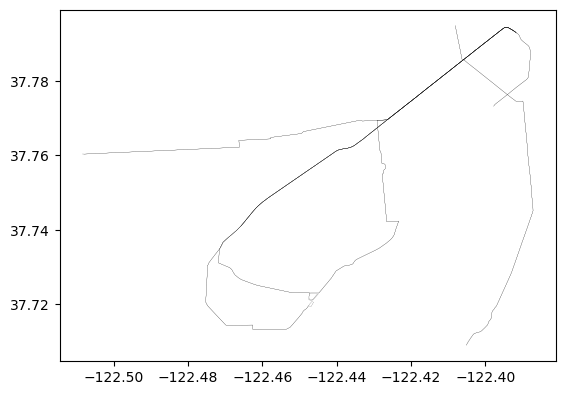

In [2166]:
gp_transit = gpd.GeoDataFrame(transit, geometry = transit["shape"].apply(shapely.wkt.loads))
gp_transit.plot(edgecolor = "black", linewidth=0.1)

Now, lets plot both the centroids of the uber data and the muni data on top of our shapefile.

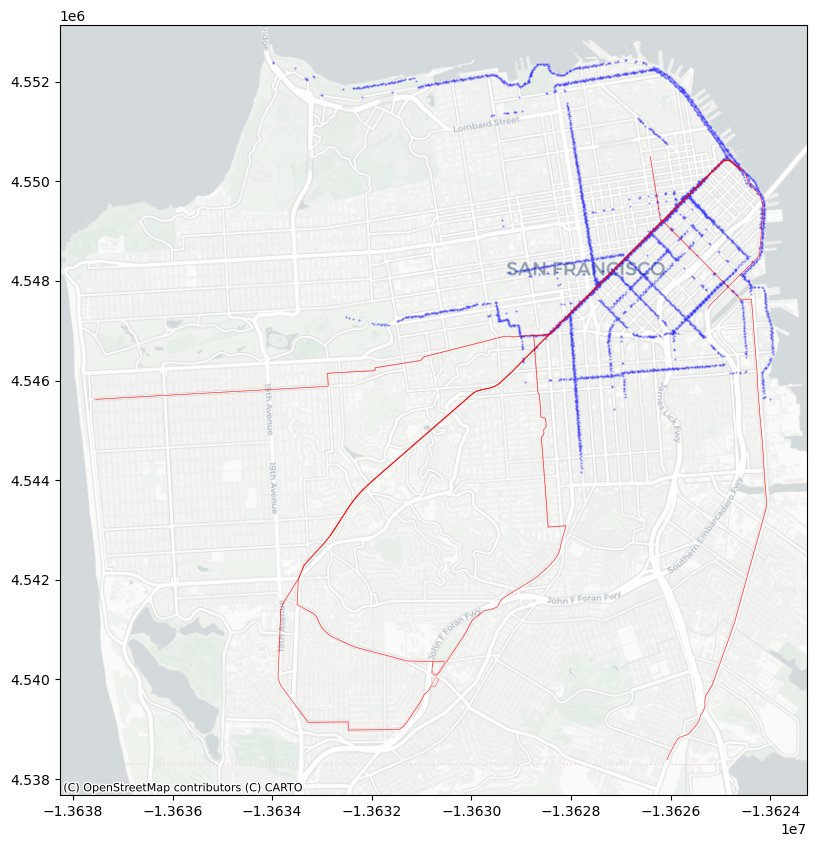

In [2167]:
gp_transit.crs = "EPSG:4326"
gp_transit = gp_transit.to_crs(epsg=3857)
# set ax
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plot transit df in red
gp_transit.plot(color="red", alpha=0.5, ax=ax, linewidth=0.5)
# plot uber df in blue
gp_df_weekday.centroid.plot(color="blue", alpha=0.5, ax=ax, markersize = 0.2)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

Already, we can see that there seems to be areas where there are lots of ubers and little light rail access. 

Lets find the centroids of this data.

In [2168]:
gp_df_weekday = gp_df_weekday.to_crs(epsg=4326)
gp_df_weekday['centroids'] = gp_df_weekday.centroid
gp_df_weekday["x_centroid"] = gp_df_weekday.centroid.x
gp_df_weekday["y_centroid"] = gp_df_weekday.centroid.y
gp_df_weekday.centroid

/var/folders/q5/dg26z3653mg6v9sr1qxw57jw0000gp/T/ipykernel_58254/2598550837.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gp_df_weekday['centroids'] = gp_df_weekday.centroid
/var/folders/q5/dg26z3653mg6v9sr1qxw57jw0000gp/T/ipykernel_58254/2598550837.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gp_df_weekday["x_centroid"] = gp_df_weekday.centroid.x
/var/folders/q5/dg26z3653mg6v9sr1qxw57jw0000gp/T/ipykernel_58254/2598550837.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gp_df_weekday["y_centroid"] = gp_df_weekday.centroid.y
/var/folders/q5/dg26z3653mg6v9s

0        POINT (-122.40210 37.77155)
1        POINT (-122.40216 37.77138)
2        POINT (-122.40265 37.77111)
7        POINT (-122.40552 37.77122)
20       POINT (-122.41155 37.77383)
                    ...             
27038    POINT (-122.45668 37.77097)
29140    POINT (-122.42574 37.77010)
30249    POINT (-122.42164 37.76012)
30804    POINT (-122.38660 37.76034)
31353    POINT (-122.45532 37.77097)
Length: 3416, dtype: geometry

Now that we have the centroids, we can start doing some analysis of geographical clustering of this data. This method was found at https://medium.com/@dey.mallika/unsupervised-learning-with-weighted-k-means-3828b708d75d

First, we need to put our data into a numpy array

In [2169]:
centroids = np.array(gp_df_weekday[["x_centroid", "y_centroid"]]).astype(float)
traversals = np.array(gp_df_weekday["traversals"]).astype(float)

Now, we will use the kmeans method with 10 clusters. We will iterate the process 1000 times to ensure that we get accurate results.

In [2170]:
kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000)
kmeans

KMeans(max_iter=1000, n_clusters=10, random_state=0)

The .fit() function puts all of our centroids into 10 different clusters.

In [2171]:
clusters = kmeans.fit(centroids, sample_weight = traversals)

/Users/benantonow/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Now, we label each of our polygons with it's cluster id from our kmeans analysis

In [2172]:
gp_df_weekday['Cluster_id'] = kmeans.labels_
gp_df_weekday

,hexid,dayType,traversals,wktGeometry,geometry,centroids,x_centroid,y_centroid,Cluster_id
0,8c283082e2561ff,weekday,1032,POLYGON ((-122.40206953427416 37.7714520565948...,"POLYGON ((-122.40207 37.77145, -122.40198 37.7...",POINT (-122.40210 37.77155),-122.402099,37.771548,0
1,8c283082e2569ff,weekday,892,POLYGON ((-122.40213131278361 37.7712839848525...,"POLYGON ((-122.40213 37.77128, -122.40204 37.7...",POINT (-122.40216 37.77138),-122.402161,37.771380,0
2,8c283082e2549ff,weekday,990,POLYGON ((-122.40261741706829 37.7710182076871...,"POLYGON ((-122.40262 37.77102, -122.40253 37.7...",POINT (-122.40265 37.77111),-122.402647,37.771114,0
7,8c283082e2687ff,weekday,919,POLYGON ((-122.4054909446929 37.77112573809673...,"POLYGON ((-122.40549 37.77113, -122.40540 37.7...",POINT (-122.40552 37.77122),-122.405520,37.771222,0
20,8c28308285455ff,weekday,665,POLYGON ((-122.41152258649674 37.7737365007458...,"POLYGON ((-122.41152 37.77374, -122.41143 37.7...",POINT (-122.41155 37.77383),-122.411552,37.773832,5
...,...,...,...,...,...,...,...,...,...
27038,8c283095a4267ff,weekday,691,POLYGON ((-122.45664688943185 37.7708705466430...,"POLYGON ((-122.45665 37.77087, -122.45656 37.7...",POINT (-122.45668 37.77097),-122.456676,37.770966,4
29140,8c2830828b813ff,weekday,633,POLYGON ((-122.42570871807595 37.7700062503614...,"POLYGON ((-122.42571 37.77001, -122.42562 37.7...",POINT (-122.42574 37.77010),-122.425738,37.770102,9
30249,8c283082c28a3ff,weekday,630,POLYGON ((-122.42160717843431 37.7600281091720...,"POLYGON ((-122.42161 37.76003, -122.42152 37.7...",POINT (-122.42164 37.76012),-122.421637,37.760124,9
30804,8c283082ece0bff,weekday,541,POLYGON ((-122.38657257100553 37.7602491836428...,"POLYGON ((-122.38657 37.76025, -122.38648 37.7...",POINT (-122.38660 37.76034),-122.386602,37.760345,7


Let's make a new df of all the clusters and the coords of its center. We'll use the unary_union.centroid function to aggregate the centroids while considering the curvature of the earth. Documentation: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.unary_union.html

In [2173]:
def cluster_center(df):
    return df.geometry.unary_union.centroid
cluster_output = gp_df_weekday.groupby("Cluster_id").apply(cluster_center)
df_centroids = pd.DataFrame()
df_centroids['Centroid'] = cluster_output
df_centroids

,Centroid
Cluster_id,
0,POINT (-122.40424843198764 37.77035113695194)
1,POINT (-122.42367854325379 37.803434773268876)
2,POINT (-122.40420624411261 37.80362649275778)
3,POINT (-122.44950706146612 37.80555365277338)
4,POINT (-122.44013288457992 37.772743327535736)
5,POINT (-122.41685228429644 37.77914051696746)
6,POINT (-122.40404209757976 37.78542707385434)
7,POINT (-122.3910952209073 37.77439067171073)
8,POINT (-122.39312454995517 37.79105199546944)


Let's plot these points!

<Axes: >

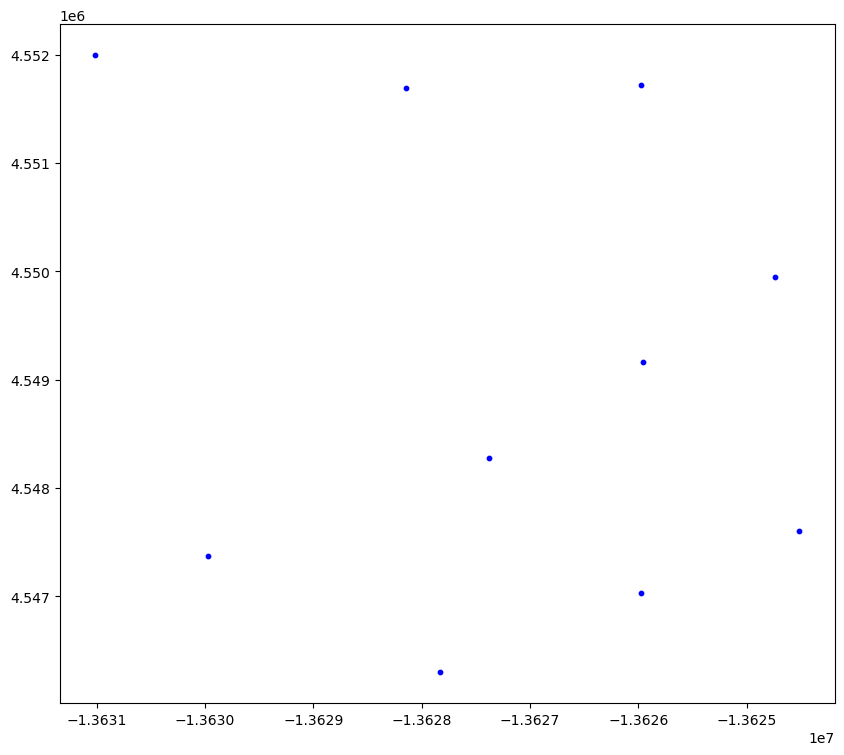

In [2174]:
gp_centers = gpd.GeoDataFrame(df_centroids, geometry='Centroid')

gp_centers.crs = "EPSG:4326"
gp_centers = gp_centers.to_crs(epsg=3857)
gp_centers.plot(figsize=(10, 10), color = "blue", markersize = 10, alpha=1.0,)

Now, for the moment of truth. Let's plot these cluster centroids on top of our San Francisco shapefile alongside our Muni Metro routes.

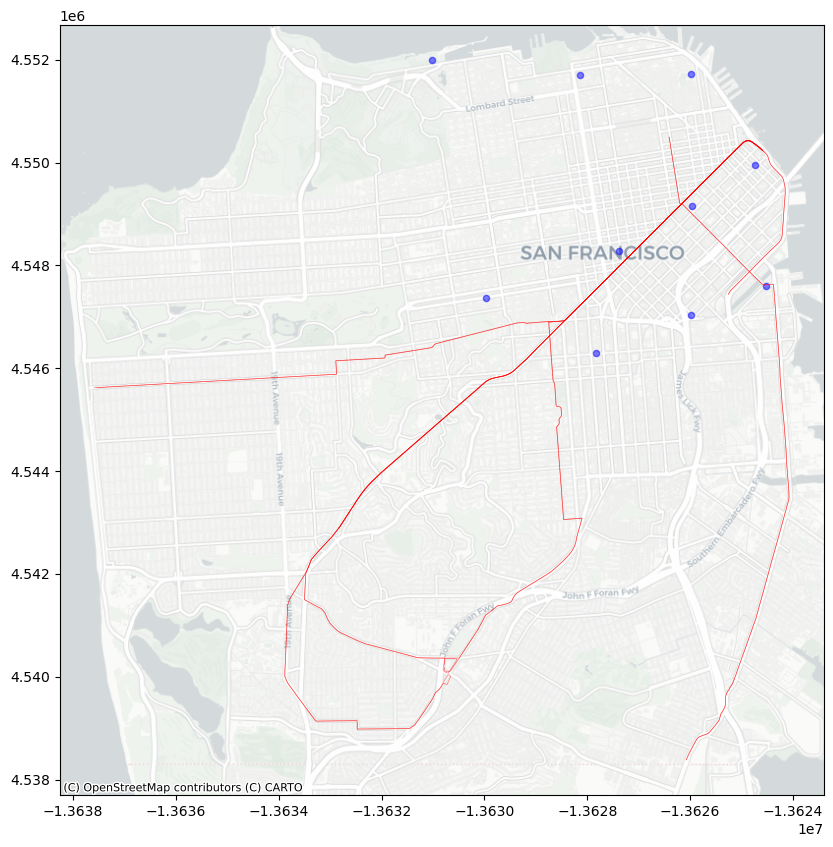

In [2175]:
# set ax
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plot transit df in red
gp_transit.plot(color="red", alpha=0.5, ax=ax, linewidth=0.5)
# plot uber df in blue
gp_centers.centroid.plot(color="blue", alpha=0.5, ax=ax, markersize = 20)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

Okay, what this analysis tells us is that there is a major area of the city where people are trying to get to that is NOT serviced by the light rail system. The northern coast of the peninsula is home to around 30% of polygons with more than 500 traversals, and would benefit from a light rail line. This has the potential to seriously reduce rideshare use, and in turn, carbon emissions in San Francisco.

Let's take a look at another dataset that tracks Muni ridership relative to pre-covid numbers.

In [2137]:
ridership = pd.read_csv("Muni_ridership_clean.csv")
ridership

,Measure Names,Month of MONTH,ROUTE_NAME,Measure Values
0,Monthly Route Recovery,February 2024,1 California,0.777145478
1,Route Monthly Total Boardings (accessible copy),February 2024,1 California,"433,000"
2,Baseline Route Monthly Total Boardings (access...,February 2024,1 California,"557,000"
3,Monthly Route Recovery,January 2024,1 California,0.743741843
4,Route Monthly Total Boardings (accessible copy),January 2024,1 California,"447,000"
...,...,...,...,...
1969,Route Monthly Total Boardings (accessible copy),March 2023,N Judah,"693,000"
1970,Baseline Route Monthly Total Boardings (access...,March 2023,N Judah,"1,200,000"
1971,Monthly Route Recovery,February 2023,N Judah,0.542915954
1972,Route Monthly Total Boardings (accessible copy),February 2023,N Judah,"589,000"


Lets just look at the percentages, and compare February 2024 to February 2023 to see more current data. We'll use a regex pattern for this.

In [2138]:
ridership = ridership[ridership['Measure Names']=="Monthly Route Recovery"]
ridership = ridership[ridership['Month of MONTH'].str.contains(r'^February\s202[3|4]')]

ridership

,Measure Names,Month of MONTH,ROUTE_NAME,Measure Values
0,Monthly Route Recovery,February 2024,1 California,0.777145478
36,Monthly Route Recovery,February 2023,1 California,0.664423295
39,Monthly Route Recovery,February 2024,2 Sutter,0.470797663
75,Monthly Route Recovery,February 2023,2 Sutter,0.358758441
78,Monthly Route Recovery,February 2024,5 Fulton,0.967641422
...,...,...,...,...
1890,Monthly Route Recovery,February 2023,J Church,0.428202455
1893,Monthly Route Recovery,February 2024,M Ocean View,0.732845322
1929,Monthly Route Recovery,February 2023,M Ocean View,0.696101308
1935,Monthly Route Recovery,February 2024,N Judah,0.641286191


Now we'll change the format of our route name so we can join it later with our transit df.

In [2139]:
def clean_route_name(val):
    return re.sub(r' .*', '', val)

ridership['ROUTE_LABEL'] = ridership['ROUTE_NAME'].apply(clean_route_name)
# one extraneous value without a feb 2023 value that we remove
ridership = ridership[ridership['ROUTE_NAME']!="28R 19th Avenue Rapid"]
ridership

,Measure Names,Month of MONTH,ROUTE_NAME,Measure Values,ROUTE_LABEL
0,Monthly Route Recovery,February 2024,1 California,0.777145478,1
36,Monthly Route Recovery,February 2023,1 California,0.664423295,1
39,Monthly Route Recovery,February 2024,2 Sutter,0.470797663,2
75,Monthly Route Recovery,February 2023,2 Sutter,0.358758441,2
78,Monthly Route Recovery,February 2024,5 Fulton,0.967641422,5
...,...,...,...,...,...
1890,Monthly Route Recovery,February 2023,J Church,0.428202455,J
1893,Monthly Route Recovery,February 2024,M Ocean View,0.732845322,M
1929,Monthly Route Recovery,February 2023,M Ocean View,0.696101308,M
1935,Monthly Route Recovery,February 2024,N Judah,0.641286191,N


Let's make a new df that removes all the feb 2023 values, just so it's easier to merge

In [2140]:
ridership_updated = ridership[ridership["Month of MONTH"].str.contains(r'2024$')]
ridership_updated

,Measure Names,Month of MONTH,ROUTE_NAME,Measure Values,ROUTE_LABEL
0,Monthly Route Recovery,February 2024,1 California,0.777145478,1
39,Monthly Route Recovery,February 2024,2 Sutter,0.470797663,2
78,Monthly Route Recovery,February 2024,5 Fulton,0.967641422,5
117,Monthly Route Recovery,February 2024,5R Fulton Rapid,0.561812730,5R
156,Monthly Route Recovery,February 2024,6 Haight/Parnassus,0.566040791,6
195,Monthly Route Recovery,February 2024,7 Haight/Noriega,1.003290662,7
234,Monthly Route Recovery,February 2024,8 Bayshore,0.766508650,8
273,Monthly Route Recovery,February 2024,8AX Bayshore A Express,0.590419749,8AX
312,Monthly Route Recovery,February 2024,8BX Bayshore B Express,0.666497346,8BX
351,Monthly Route Recovery,February 2024,9 San Bruno,1.085307456,9


We need to iterate through each route in the dataframe to find the percent change between feb 2023 and 2024 for each value

In [2141]:
ridership_updated["Percent_change"] = ridership_updated["Measure Values"]
ridership_groups = ridership.groupby("Month of MONTH")

/var/folders/q5/dg26z3653mg6v9sr1qxw57jw0000gp/T/ipykernel_58254/4121360172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridership_updated["Percent_change"] = ridership_updated["Measure Values"]


In [2142]:
for i in range(ridership_updated["Percent_change"].size):
    ridership_updated["Percent_change"].iloc[i] = (float(ridership_groups.get_group("February 2024")["Measure Values"].iloc[i]) - float(ridership_groups.get_group("February 2023")["Measure Values"].iloc[i]))

ridership_updated

/var/folders/q5/dg26z3653mg6v9sr1qxw57jw0000gp/T/ipykernel_58254/2518335255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridership_updated["Percent_change"].iloc[i] = (float(ridership_groups.get_group("February 2024")["Measure Values"].iloc[i]) - float(ridership_groups.get_group("February 2023")["Measure Values"].iloc[i]))
/var/folders/q5/dg26z3653mg6v9sr1qxw57jw0000gp/T/ipykernel_58254/2518335255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridership_updated["Percent_change"].iloc[i] = (float(ridership_groups.get_group("February 2024")["Measure Values"].iloc[i]) - float(ridership_groups.get_group("Februa

,Measure Names,Month of MONTH,ROUTE_NAME,Measure Values,ROUTE_LABEL,Percent_change
0,Monthly Route Recovery,February 2024,1 California,0.777145478,1,0.112722
39,Monthly Route Recovery,February 2024,2 Sutter,0.470797663,2,0.112039
78,Monthly Route Recovery,February 2024,5 Fulton,0.967641422,5,0.063395
117,Monthly Route Recovery,February 2024,5R Fulton Rapid,0.561812730,5R,0.062414
156,Monthly Route Recovery,February 2024,6 Haight/Parnassus,0.566040791,6,0.096436
195,Monthly Route Recovery,February 2024,7 Haight/Noriega,1.003290662,7,0.096452
234,Monthly Route Recovery,February 2024,8 Bayshore,0.766508650,8,0.060194
273,Monthly Route Recovery,February 2024,8AX Bayshore A Express,0.590419749,8AX,0.063293
312,Monthly Route Recovery,February 2024,8BX Bayshore B Express,0.666497346,8BX,0.065933
351,Monthly Route Recovery,February 2024,9 San Bruno,1.085307456,9,0.054534


Now, the percent change is listed in its own column. Let's inner merge it with our transit df so we can see which routes the ridership data had.

In [2143]:
transit = transit.merge(ridership_updated, left_on="ROUTE_NAME", right_on="ROUTE_LABEL", how='inner')
transit

,PATTERN,PATTERNID,ROUTE_NAME_x,DIRECTION,PATTERN_TYPE,SUB_TYPE,PATTERN_VERSION,LINEABBR,SIGNID,SERVICE_CA,shape,Measure Names,Month of MONTH,ROUTE_NAME_y,Measure Values,ROUTE_LABEL,Percent_change
0,J O F00,209575,J,O,F,0,0,J,142,Muni Metro,"MULTILINESTRING ((-122.39171 37.79305, -122.39...",Monthly Route Recovery,February 2024,J Church,0.513524006,J,0.085322
1,J I F00,209579,J,I,F,0,0,J,142,Muni Metro,"MULTILINESTRING ((-122.44736 37.721684, -122.4...",Monthly Route Recovery,February 2024,J Church,0.513524006,J,0.085322
2,M O F00,209630,M,O,F,0,0,M,142,Muni Metro,"MULTILINESTRING ((-122.39171 37.79305, -122.39...",Monthly Route Recovery,February 2024,M Ocean View,0.732845322,M,0.036744
3,M I F00,209641,M,I,F,0,0,M,142,Muni Metro,"MULTILINESTRING ((-122.44656 37.720623, -122.4...",Monthly Route Recovery,February 2024,M Ocean View,0.732845322,M,0.036744
4,N O F01,209657,N,O,F,0,1,N,142,Muni Metro,"MULTILINESTRING ((-122.397766 37.773186, -122....",Monthly Route Recovery,February 2024,N Judah,0.641286191,N,0.09837
5,N I F01,209669,N,I,F,0,1,N,142,Muni Metro,"MULTILINESTRING ((-122.508125 37.760303, -122....",Monthly Route Recovery,February 2024,N Judah,0.641286191,N,0.09837


Looks like all the routes we have data on have positive values in the Percent_change column, so they are INCREASING in ridership, suggesting an increase in popularity of San Francisco's light rail system! All the more reason to expand it!